### Proyecto intermodular Enero

In [1]:
# ==============================
# IMPORTACIÓN DE LIBRERÍAS
# ==============================

# ------------------------------------------------------------
# import pandas as pd:
#   - Manipulación de datos tabulares con DataFrames.
# ------------------------------------------------------------
import pandas as pd

# ------------------------------------------------------------
# import matplotlib.pyplot as plt:
#   - Visualización 2D con Matplotlib (figuras, ejes y gráficos).
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# from sklearn.model_selection import train_test_split:
#   - División reproducible en train/test (opcional: stratify para clasificación).
# ------------------------------------------------------------
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
# from src.utils import load_yaml:
#   - Carga archivos YAML y retorna la configuración como dict.
#   - Carga datasets desde ruta (p. ej., CSV/Parquet/Excel) y retorna un DataFrame.
# ------------------------------------------------------------
from src.utils import load_yaml, load_dataset


In [2]:
# ==============================
# IMPORTACIÓN DE MÓDULOS DEL PROYECTO
# ==============================

# ------------------------------------------------------------
# from src.eda_helper import EDAHelper:
#   - Utilidades para EDA (resúmenes, nulos, distribuciones, correlaciones y gráficos).
# ------------------------------------------------------------
from src.eda_helper import EDAHelper

# ------------------------------------------------------------
# from src.preprocessing import DataPreprocessor:
#   - Preprocesamiento y feature engineering (fit/transform) evitando leakage.
# ------------------------------------------------------------
from src.preprocessing import DataPreprocessor

# ------------------------------------------------------------
# from src.reporting import ReportBuilder:
#   - Construcción de reportes/figuras y resumen de resultados del pipeline.
# ------------------------------------------------------------
from src.reporting import ReportBuilder

# ------------------------------------------------------------
# from src.training import Training:
#   - Entrenamiento y evaluación (holdout/CV) + métricas/persistencia.
# ------------------------------------------------------------
from src.training import Training

# ------------------------------------------------------------
# from src.model_manager import ModelManager:
#   - Gestión de modelos: guardado/carga, versionado y selección de ganadores.
# ------------------------------------------------------------
from src.model_manager import ModelManager


In [3]:
# ==============================
# CONFIGURACIÓN DEL PIPELINE
# ==============================

# ------------------------------------------------------------
# cfg:
#   - Configuración cargada desde YAML para controlar el pipeline sin tocar código.
#   - Estructura: cfg["seccion"]["parametro"].
# ------------------------------------------------------------
cfg = load_yaml("config.yml")

# ==============================
# RUTAS
# ==============================

# ------------------------------------------------------------
# DATASET_TRAIN / MODELS_DIR:
#   - DATASET_TRAIN → ruta del dataset de entrenamiento.
#   - MODELS_DIR    → salida de modelos y artefactos (preprocesador, metadata, etc.).
# ------------------------------------------------------------
DATASET_TRAIN  = cfg["paths"]["dataset_train"]
MODELS_DIR     = cfg["paths"]["models_dir"]

# ==============================
# TARGET
# ==============================

# ------------------------------------------------------------
# TARGET / VALUE_TARGET:
#   - TARGET       → nombre de la columna objetivo en el DataFrame.
#   - VALUE_TARGET → clase/valor “positivo” o de interés (para binaria o reglas del negocio).
# ------------------------------------------------------------
TARGET         = cfg["target"]["col"]
VALUE_TARGET   = cfg["target"]["value"]

# ==============================
# PARÁMETROS GENERALES
# ==============================

# ------------------------------------------------------------
# MAX_EXAMPLES / SEP_LEN:
#   - MAX_EXAMPLES → límite de registros para pruebas rápidas (si se aplica en el flujo).
#   - SEP_LEN      → longitud de separadores/formatos para prints/logs.
# ------------------------------------------------------------
MAX_EXAMPLES   = cfg["config"]["max_examples"]
SEP_LEN        = cfg["config"]["sep_len"]

# ==============================
# SPLIT TRAIN / TEST
# ==============================

# ------------------------------------------------------------
# TEST_SIZE / RANDOM_STATE / USE_STRATIFY:
#   - TEST_SIZE    → proporción/tamaño del set de prueba.
#   - RANDOM_STATE → semilla para reproducibilidad del split.
#   - USE_STRATIFY → mantiene proporción de clases del target (recomendado en clasificación).
# ------------------------------------------------------------
TEST_SIZE      = cfg["split"]["test_size"]
RANDOM_STATE   = cfg["split"]["random_state"]
USE_STRATIFY   = cfg["split"]["stratify"]

# ==============================
# CROSS-VALIDATION
# ==============================

# ------------------------------------------------------------
# CV_SPLITS / CV_SHUFFLE / CV_RS:
#   - CV_SPLITS  → número de folds.
#   - CV_SHUFFLE → mezcla antes de crear folds (si aplica).
#   - CV_RS      → semilla cuando hay shuffle (reproducibilidad).
# ------------------------------------------------------------
CV_SPLITS      = cfg["cv"]["n_splits"]
CV_SHUFFLE     = cfg["cv"]["shuffle"]
CV_RS          = cfg["cv"]["random_state"]

# ==============================
# FLAGS
# ==============================

# ------------------------------------------------------------
# RUN_*:
#   - RUN_DROP_STATIC      → elimina variables constantes / casi constantes.
#   - RUN_TRANSFORMATION   → aplica transformaciones/feature engineering.
#   - RUN_DROP_CORRELATED  → elimina variables altamente correlacionadas.
#   - RUN_CROSS_VALIDATION → ejecuta CV sobre el train.
# ------------------------------------------------------------
RUN_DROP_STATIC      = cfg["flags"]["run_drop_static"]
RUN_TRANSFORMATION   = cfg["flags"]["run_transformation"]
RUN_DROP_CORRELATED  = cfg["flags"]["run_drop_correlated"]
RUN_CROSS_VALIDATION = cfg["flags"]["run_cross_validation"]
RUN_THIS_CELL        = cfg["flags"]["run_this_cell"]


In [4]:
# ==============================
# INICIALIZACIÓN DE COMPONENTES DEL PIPELINE
# ==============================

# ------------------------------------------------------------
# EDA = EDAHelper(TARGET, MAX_EXAMPLES, SEP_LEN):
#   - Instancia el componente de EDA para análisis exploratorio y utilidades de diagnóstico.
#   - Entradas:
#       * TARGET       → nombre/clave de la variable objetivo.
#       * MAX_EXAMPLES → límite de ejemplos/filas a mostrar en salidas/resúmenes.
#       * SEP_LEN      → longitud de separadores para formateo visual en prints/reportes.
#   - Resultado:
#       * `EDA` queda listo para ejecutar resúmenes, validaciones y visualizaciones rápidas.
# ------------------------------------------------------------
EDA = EDAHelper(TARGET, MAX_EXAMPLES, SEP_LEN)

# ------------------------------------------------------------
# DataPreprocessor = DataPreprocessor():
#   - Crea el preprocesador responsable de transformar datos crudos a features de modelado.
#   - Nota técnica:
#       * Aquí el nombre de variable (`DataPreprocessor`) colisiona con el nombre de la clase.
#         Esto oculta la referencia a la clase en el resto del script.
#       * Recomendación habitual: usar `preprocessor = DataPreprocessor()` para evitar sombra.
# ------------------------------------------------------------
DataPreprocessor = DataPreprocessor()

# ------------------------------------------------------------
# Reporting = ReportBuilder():
#   - Inicializa el generador de reportes del flujo (tablas, métricas, figuras, exportaciones).
#   - Deja listo el componente para ir agregando secciones y construir el reporte final.
# ------------------------------------------------------------
Reporting = ReportBuilder()

# ------------------------------------------------------------
# Training = Training():
#   - Inicializa el orquestador de entrenamiento/evaluación.
#   - Gestiona ejecuciones (holdout/full), cálculo de métricas y persistencia de artefactos.
# ------------------------------------------------------------
Training = Training()

# ------------------------------------------------------------
# ModelManager = ModelManager():
#   - Inicializa el gestor de modelos (carga/guardado, selección de ganadores, versionado).
#   - Se usa para consolidar resultados y operar sobre el inventario de modelos persistidos.
# ------------------------------------------------------------
ModelManager = ModelManager()


In [5]:
# ==============================
# CONSTRUCCIÓN Y RESUMEN DE VARIANTES DE MODELO
# ==============================

# ------------------------------------------------------------
# MODEL_VARIANTS = ModelManager.build_model_variants_from_config(cfg):
#   - Genera variantes desde `cfg` combinando algoritmo, receta de variante, hiperparámetros y umbral.
#   - Parámetro:
#       * cfg → dict de configuración (sección de modelos/escenarios) usada para armar combinaciones.
#   - Retorno:
#       * MODEL_VARIANTS → dict con metadatos por variante (id, model_key, variant_id, class_name, threshold, params).
# ------------------------------------------------------------
MODEL_VARIANTS = ModelManager.build_model_variants_from_config(cfg)
print(f"\nVariantes construidas: {len(MODEL_VARIANTS)}")

# ------------------------------------------------------------
# rows:
#   - Acumulador para crear un DataFrame resumen a partir de MODEL_VARIANTS.
# ------------------------------------------------------------
rows = []

# ------------------------------------------------------------
# for variant in MODEL_VARIANTS.values():
#   - Extrae campos clave para inspección:
#       * id        → identificador único de la variante.
#       * model_key → familia/algoritmo (p. ej., "logreg", "rf", "xgb").
#       * variant_id→ nombre de la receta/configuración dentro del algoritmo.
#       * class_name→ clase real del estimador (auditoría).
#       * threshold → umbral de decisión (si el flujo binariza probabilidades/scores).
#       * params    → hiperparámetros aplicados al estimador.
# ------------------------------------------------------------
for variant in MODEL_VARIANTS.values():
    rows.append({
        "id": variant["id"],
        "model": variant["model_key"],
        "variant": variant["variant_id"],
        "class": variant["class_name"],
        "threshold": variant["threshold"],
        "params": variant["params"],
    })

# ------------------------------------------------------------
# VARIANTS_DF:
#   - Tabla consolidada y ordenada por (model, variant) para comparación y depuración.
# ------------------------------------------------------------
VARIANTS_DF = (
    pd.DataFrame(rows)
      .sort_values(["model", "variant"])
      .reset_index(drop=True)
)

# ------------------------------------------------------------
# display(VARIANTS_DF):
#   - Visualiza el resumen tabular de variantes y sus parámetros.
# ------------------------------------------------------------
display(VARIANTS_DF)



Variantes construidas: 2


,id,model,variant,class,threshold,params
0,RandomForest__balanced,RandomForest,balanced,RandomForestClassifier,0.5,"{'random_state': 42, 'n_estimators': 500, 'max..."
1,RandomForest__normal,RandomForest,normal,RandomForestClassifier,0.5,"{'random_state': 42, 'n_estimators': 300, 'max..."


In [6]:
# ==============================
# CARGA DEL DATASET DE ENTRENAMIENTO
# ==============================

# ------------------------------------------------------------
# df = EDA.load_dataset(DATASET_TRAIN):
#   - Carga el dataset desde `DATASET_TRAIN` y lo retorna como DataFrame.
#   - Parámetro:
#       * DATASET_TRAIN → ruta (str) al archivo de entrenamiento.
#   - Retorno:
#       * df → pandas.DataFrame listo para EDA/preprocesamiento.
# ------------------------------------------------------------
df = load_dataset(DATASET_TRAIN)

# ==============================
# INSPECCIÓN RÁPIDA
# ==============================

# ------------------------------------------------------------
# df.head(5):
#   - Muestra 5 filas para validar columnas, valores y nulos evidentes (no modifica `df`).
# ------------------------------------------------------------
df.head(5)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,38,Travel_Frequently,693,Research & Development,7,3,Life Sciences,1,1382,4,...,80,3,4,2,3,4,2,0,3,No
1,36,Travel_Rarely,928,Sales,1,2,Life Sciences,1,857,2,...,80,1,18,1,2,18,14,4,11,No
2,42,Travel_Rarely,855,Research & Development,12,3,Medical,1,1768,2,...,80,3,7,6,2,5,3,0,4,No
3,40,Travel_Rarely,1342,Sales,9,2,Medical,1,1548,1,...,80,0,9,5,4,8,4,7,1,No
4,38,Travel_Frequently,240,Research & Development,2,4,Life Sciences,1,803,1,...,80,0,17,2,3,15,7,4,12,No


In [7]:
# ==============================
# LIMPIEZA DE VALORES FALTANTES
# ==============================

# ------------------------------------------------------------
# df = EDA.clean_missing(df, verbose=True):
#   - Aplica estrategia de limpieza/imputación de valores faltantes sobre `df`.
#   - Parámetros:
#       * df      → DataFrame de entrada a limpiar.
#       * verbose → si True, imprime resumen de nulos y acciones aplicadas.
#   - Retorno:
#       * df → DataFrame actualizado tras el tratamiento de missing values.
# ------------------------------------------------------------
df = EDA.clean_missing(df, verbose=True)

# ------------------------------------------------------------
# df.head(5):
#   - Verificación rápida post-limpieza.
# ------------------------------------------------------------
df.head(5)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,38,Travel_Frequently,693,Research & Development,7,3,Life Sciences,1,1382,4,...,80,3,4,2,3,4,2,0,3,No
1,36,Travel_Rarely,928,Sales,1,2,Life Sciences,1,857,2,...,80,1,18,1,2,18,14,4,11,No
2,42,Travel_Rarely,855,Research & Development,12,3,Medical,1,1768,2,...,80,3,7,6,2,5,3,0,4,No
3,40,Travel_Rarely,1342,Sales,9,2,Medical,1,1548,1,...,80,0,9,5,4,8,4,7,1,No
4,38,Travel_Frequently,240,Research & Development,2,4,Life Sciences,1,803,1,...,80,0,17,2,3,15,7,4,12,No


In [8]:
# ==============================
# ELIMINACIÓN DE COLUMNAS NO INFORMATIVAS
# ==============================

# ------------------------------------------------------------
# DROP_USELESS_COLS:
#   - Columnas típicamente constantes o identificadores (ruido / no generalizan).
# ------------------------------------------------------------
DROP_USELESS_COLS = [
    "EmployeeCount",
    "EmployeeNumber",
    "Over18",
    "StandardHours"
]

# ------------------------------------------------------------
# if RUN_DROP_STATIC:
#   - Controla esta etapa desde config.
#   - DataPreprocessor.drop_columns(df, cols) elimina columnas listadas.
#   - Parámetros:
#       * df   → DataFrame de entrada.
#       * cols → lista de columnas a eliminar.
#   - Retorno:
#       * df → DataFrame sin dichas columnas (si existen).
# ------------------------------------------------------------
if RUN_DROP_STATIC:
    df = DataPreprocessor.drop_columns(df, DROP_USELESS_COLS)


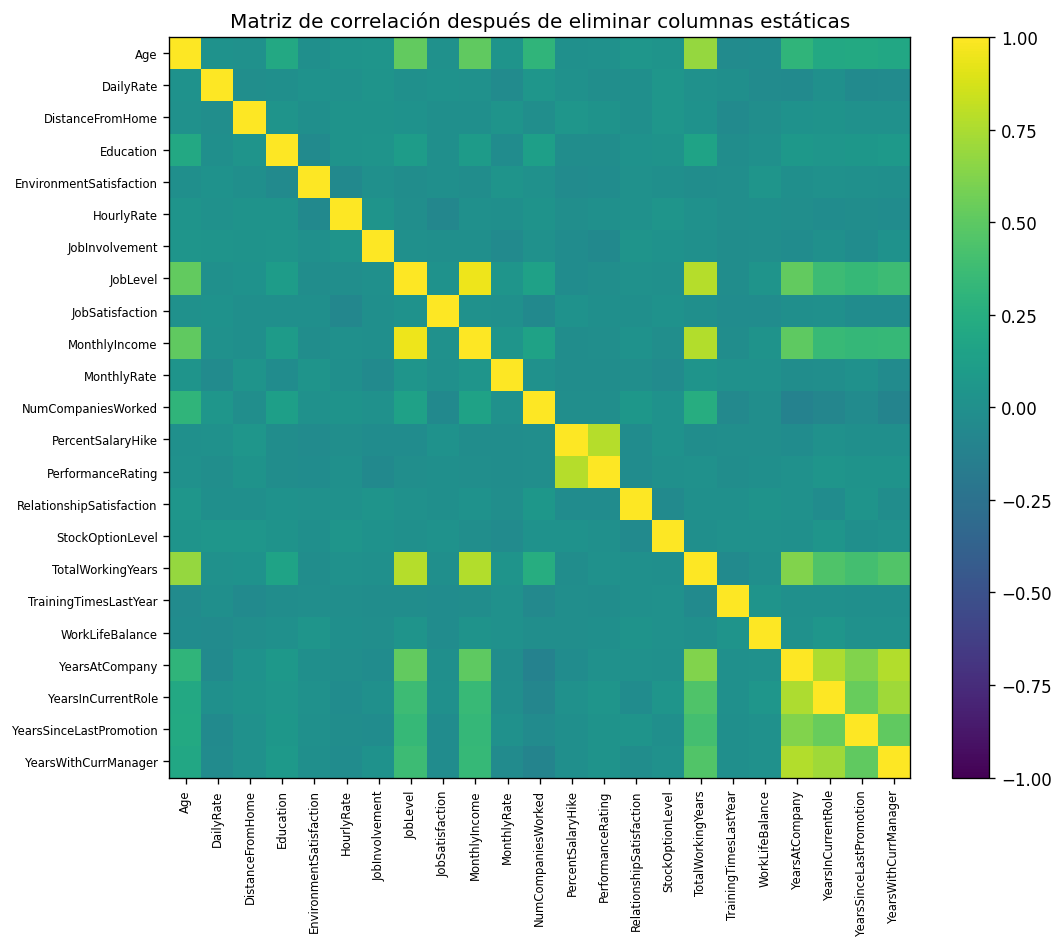

In [9]:
# ==============================
# MATRIZ DE CORRELACIÓN POST-ELIMINACIÓN DE COLUMNAS ESTÁTICAS
# ==============================

# ------------------------------------------------------------
# ReportBuilder.plot_correlation_matrix(df, plt, "Título"):
#   - Calcula y grafica la matriz de correlación usando el `df` ya depurado (sin columnas estáticas).
#   - Parámetros:
#       * df    → DataFrame (idealmente numérico) tras eliminar variables constantes/no informativas.
#       * plt   → matplotlib.pyplot para renderizar el heatmap.
#       * title → título del gráfico para identificar la etapa del pipeline.
# ------------------------------------------------------------
ReportBuilder.plot_correlation_matrix(df, plt, "Matriz de correlación después de eliminar columnas estáticas")


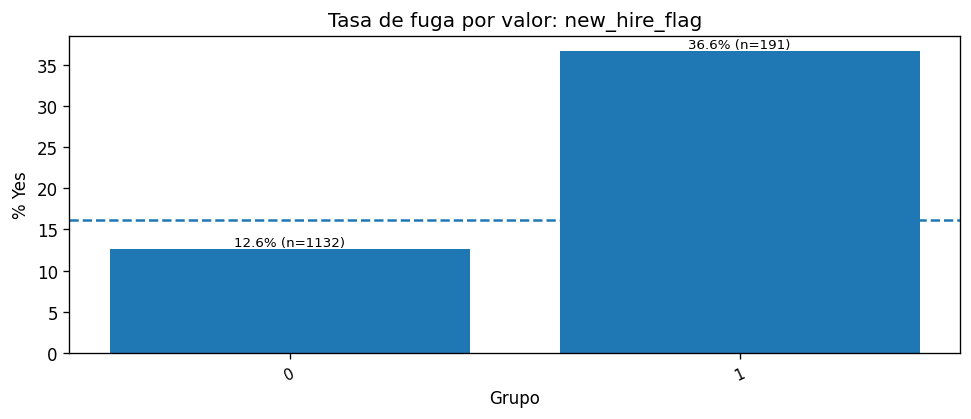

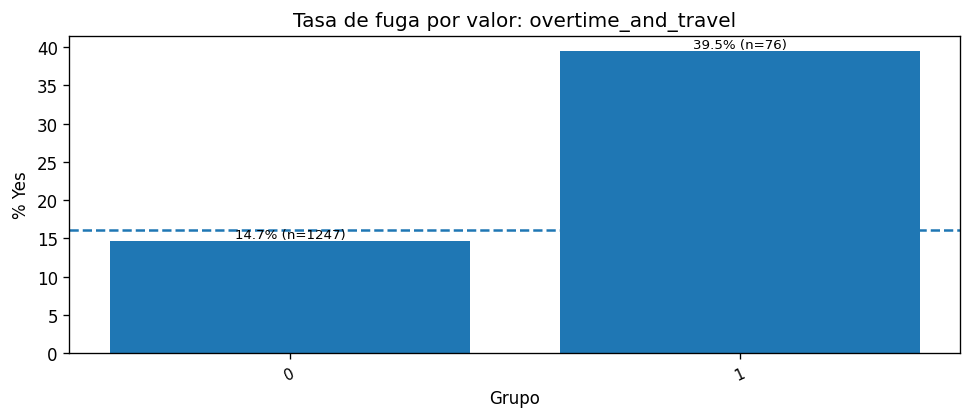

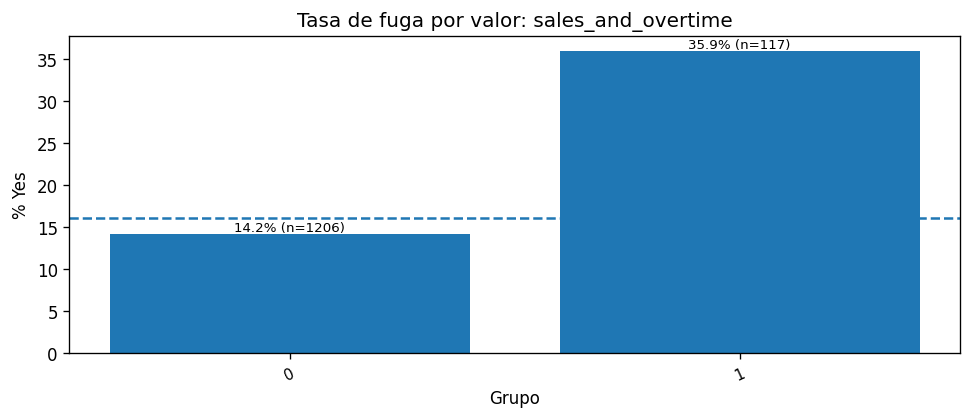

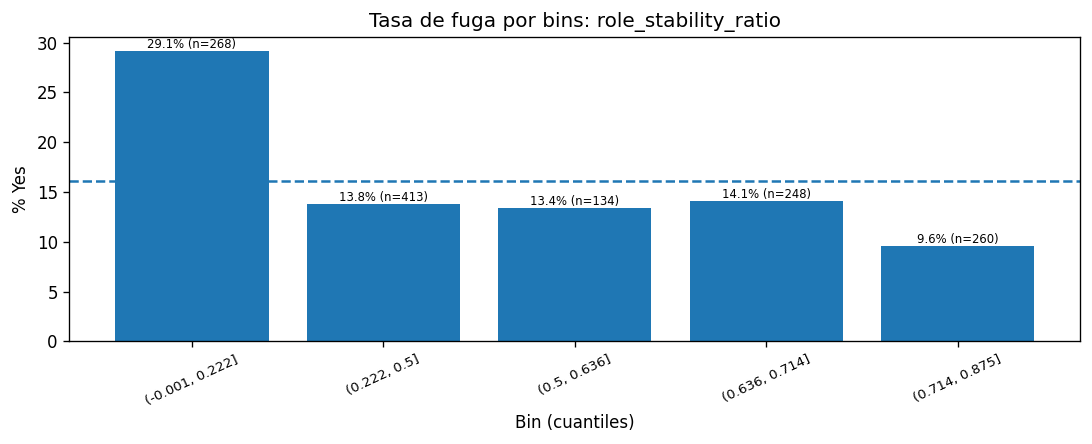

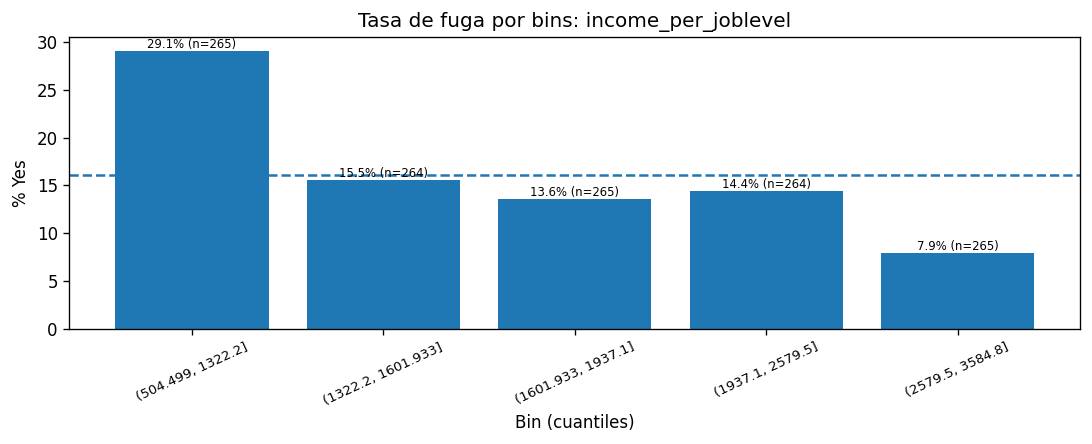

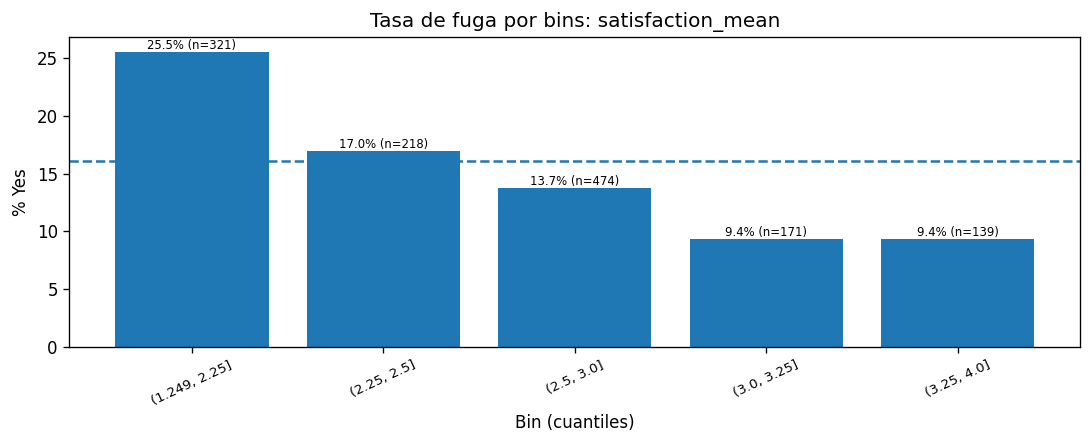

Tasa base (Attrition=Yes): 16.10%


In [10]:
# ==============================
# TRANSFORMACIÓN Y FEATURE ENGINEERING
# ==============================

# ------------------------------------------------------------
# if RUN_TRANSFORMATION:
#   - Controla desde config la creación de nuevas variables y su análisis inicial.
# ------------------------------------------------------------
if RUN_TRANSFORMATION:

    # ------------------------------------------------------------
    # df = DataPreprocessor.add_feature_engineering(df):
    #   - Añade variables derivadas al DataFrame (features nuevas para mejorar señal del modelo).
    #   - Parámetro:
    #       * df → DataFrame base.
    #   - Retorno:
    #       * df → DataFrame con columnas nuevas incorporadas.
    # ------------------------------------------------------------
    df = DataPreprocessor.add_feature_engineering(df)

    # ------------------------------------------------------------
    # new_cols:
    #   - Lista de features creadas a evaluar (debe coincidir con nombres generados en el paso anterior).
    # ------------------------------------------------------------
    new_cols = [
        "new_hire_flag",
        "overtime_and_travel",
        "sales_and_overtime",
        "role_stability_ratio",
        "income_per_joblevel",
        "satisfaction_mean"
    ]

    # ------------------------------------------------------------
    # ReportBuilder.plot_attrition_rate_for_features(...):
    #   - Grafica la tasa del target por feature (útil para validar señal y detectar patrones).
    #   - Parámetros:
    #       * df                   → DataFrame ya transformado.
    #       * target_col           → columna objetivo (TARGET).
    #       * target_positive_value→ valor/clase positiva (VALUE_TARGET).
    #       * feature_cols         → lista de features a analizar (new_cols).
    #       * plt                  → matplotlib.pyplot para renderizado.
    # ------------------------------------------------------------
    ReportBuilder.plot_attrition_rate_for_features(
        df,
        target_col=TARGET,
        target_positive_value=VALUE_TARGET,
        feature_cols=new_cols,
        plt=plt
    )


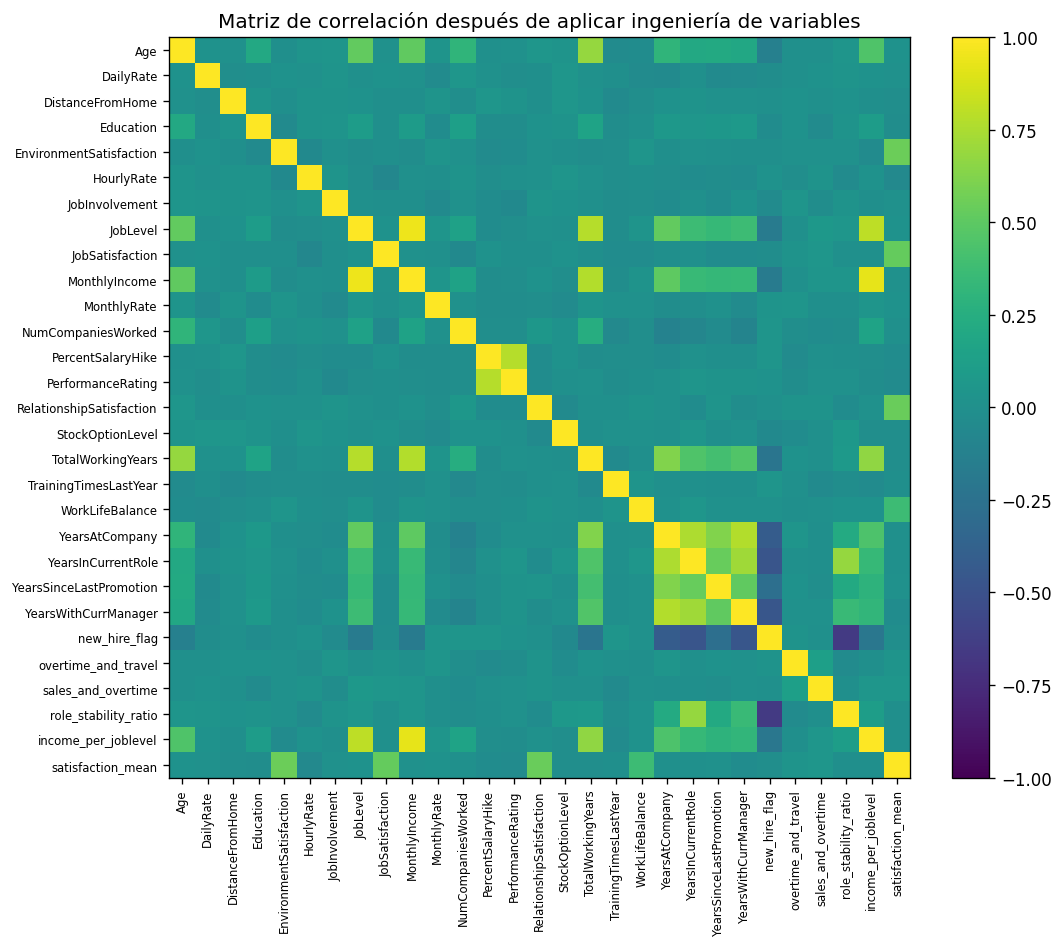

In [11]:
# ==============================
# MATRIZ DE CORRELACIÓN POST-INGENIERÍA DE VARIABLES
# ==============================

# ------------------------------------------------------------
# ReportBuilder.plot_correlation_matrix(df, plt, "Título"):
#   - Calcula y grafica correlaciones usando el `df` ya transformado (con features nuevas).
#   - Parámetros:
#       * df    → DataFrame post-feature engineering (idealmente columnas numéricas).
#       * plt   → matplotlib.pyplot para renderizar el heatmap.
#       * title → título del gráfico para identificar la etapa del pipeline.
# ------------------------------------------------------------
ReportBuilder.plot_correlation_matrix(df, plt, "Matriz de correlación después de aplicar ingeniería de variables")


In [12]:
# ==============================
# LISTA DE COLUMNAS A ELIMINAR POR CORRELACIÓN / REDUNDANCIA
# ==============================

# ------------------------------------------------------------
# DROP_CORRELATED_COLS:
#   - Lista explícita de columnas candidatas a eliminar por alta correlación o redundancia informativa.
#   - Propósito:
#       * Reducir dimensionalidad y multicolinealidad.
#       * Evitar duplicidad de señal entre variables que capturan conceptos similares.
#       * Simplificar el modelo y mejorar estabilidad (especialmente en modelos lineales).
#
# Notas técnicas:
#   - Esta lista suele construirse tras un análisis de correlación (Pearson/Spearman) en variables numéricas
#     o mediante criterios alternativos (VIF, mutual information, análisis de importancia, etc.).
#   - En presencia de features categóricas transformadas con OHE, la correlación puede cambiar:
#       * aplicar esta lista preferentemente antes de OHE (sobre columnas originales) si corresponde al análisis.
#   - Validar siempre:
#       * que las columnas existan en el DataFrame
#       * que no se esté eliminando una variable crítica para el negocio/interpretación
# ------------------------------------------------------------
DROP_CORRELATED_COLS = [
    "EnvironmentSatisfaction",
    "JobLevel",
    "JobSatisfaction",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "TotalWorkingYears",
    "WorkLifeBalance",
    "YearsInCurrentRole",
    "YearsWithCurrManager"
]

# ------------------------------------------------------------
# df = drop_columns(df, DROP_CORRELATED_COLS):
#   - Elimina del DataFrame las columnas listadas en DROP_CORRELATED_COLS.
#   - Propósito:
#       * Reducir dimensionalidad y ruido.
#       * Evitar variables constantes o identificadores que no generalizan.
#   - Entradas:
#       * df        → DataFrame original.
#       * DROP_CORRELATED_COLS → lista de nombres de columnas a eliminar.
#   - Salida:
#       * df → nuevo DataFrame sin las columnas indicadas (o el mismo si no se eliminaron).
#   - Notas técnicas:
#       * Se asume implementación en src.functions.
#       * Buenas prácticas en la implementación:
#           * ignorar columnas inexistentes (errors="ignore") o reportarlas de forma controlada.
#           * devolver copia/objeto resultante sin efectos colaterales no documentados.
# ------------------------------------------------------------
if RUN_DROP_CORRELATED:
    df = DataPreprocessor.drop_columns(df, DROP_CORRELATED_COLS)


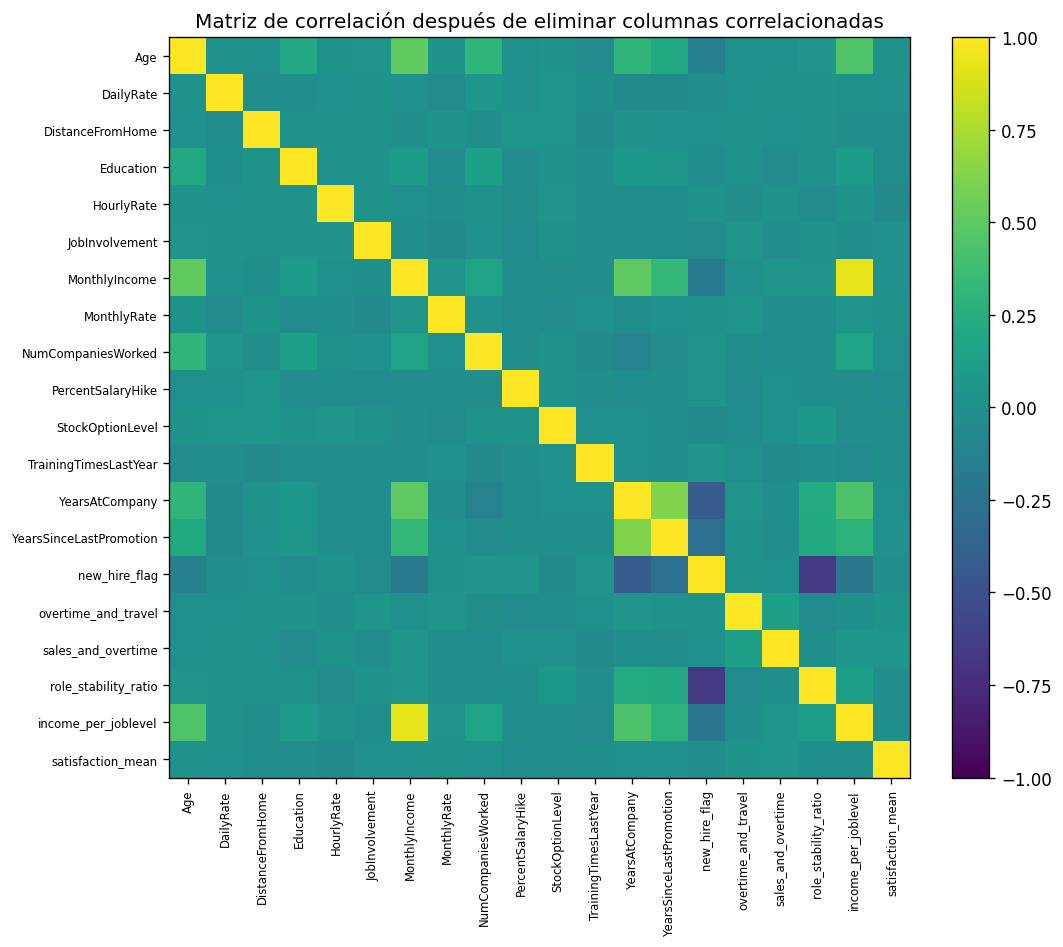

In [13]:
# ==============================
# MATRIZ DE CORRELACIÓN POST-ELIMINACIÓN DE VARIABLES CORRELACIONADAS
# ==============================

# ------------------------------------------------------------
# ReportBuilder.plot_correlation_matrix(df, plt, "Título"):
#   - Grafica la correlación con el `df` ya filtrado para reducir multicolinealidad.
#   - Parámetros:
#       * df    → DataFrame final tras eliminar variables altamente correlacionadas.
#       * plt   → matplotlib.pyplot para renderizar el heatmap.
#       * title → título del gráfico para marcar la etapa del pipeline.
# ------------------------------------------------------------
ReportBuilder.plot_correlation_matrix(df, plt, "Matriz de correlación después de eliminar columnas correlacionadas")


In [14]:
# ==============================
# DIAGNÓSTICO DE OUTLIERS (IQR)
# ==============================

if RUN_THIS_CELL:
    # ------------------------------------------------------------
    # summary = EDA.iqr_outlier_summary(df, TARGET, DROP_USELESS_COLS):
    #   - Calcula outliers por IQR en variables numéricas (excluye TARGET y columnas indicadas).
    #   - Parámetros:
    #       * df               → DataFrame a analizar.
    #       * TARGET           → columna objetivo a excluir.
    #       * DROP_USELESS_COLS→ columnas a excluir (IDs/constantes/no útiles).
    #   - Retorno:
    #       * summary → tabla con conteo/% de outliers y límites IQR por variable (según implementación).
    # ------------------------------------------------------------
    summary = EDA.iqr_outlier_summary(df, TARGET, DROP_USELESS_COLS)

    # ------------------------------------------------------------
    # display(summary):
    #   - Inspección rápida del ranking de variables con más outliers.
    # ------------------------------------------------------------
    display(summary)

    # ------------------------------------------------------------
    # EDA.plot_outlier_pct_bar(summary, top_n, plt):
    #   - Barplot del % de outliers por variable (top_n = 5).
    # ------------------------------------------------------------
    EDA.plot_outlier_pct_bar(summary, 5, plt)

    # ------------------------------------------------------------
    # EDA.plot_boxplots_top_outliers(df, summary, TARGET, top_n, plt):
    #   - Boxplots de las variables con más outliers para validar distribución (top_n = 5).
    # ------------------------------------------------------------
    EDA.plot_boxplots_top_outliers(df, summary, TARGET, 5, plt)


In [15]:
# ==============================
# CONSTRUCCIÓN DE X/Y + SPLIT + PREPROCESADOR
# ==============================

# ------------------------------------------------------------
# y = (df[TARGET] == VALUE_TARGET).astype(int):
#   - Target binario: 1 si TARGET == VALUE_TARGET, si no 0.
#   - Parámetros:
#       * TARGET       → columna objetivo en `df`.
#       * VALUE_TARGET → valor/clase considerada positiva.
# ------------------------------------------------------------
y = (df[TARGET] == VALUE_TARGET).astype(int)

# ------------------------------------------------------------
# X = df.drop(columns=[TARGET]).copy():
#   - Features sin la columna objetivo (evita leakage directo).
#   - Parámetro:
#       * TARGET → columna a eliminar de `df`.
# ------------------------------------------------------------
X = df.drop(columns=[TARGET]).copy()

# ------------------------------------------------------------
# STRATIFY:
#   - Si USE_STRATIFY=True, mantiene proporción de clases en train/test usando `y`.
# ------------------------------------------------------------
STRATIFY = y if USE_STRATIFY else None

# ------------------------------------------------------------
# train_test_split(...):
#   - Divide en train/test con control de tamaño y reproducibilidad.
#   - Parámetros:
#       * test_size    → %/tamaño del set de prueba.
#       * random_state → semilla para reproducibilidad.
#       * stratify     → y (si estratifica) o None.
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    stratify=STRATIFY,
    test_size=TEST_SIZE
)


# Añadir flags a train y test usando límites aprendidos en train
X_train_flag = EDA.add_iqr_outlier_flags_by_class(X_train, y_train, X_train, y_train, k=1.5)
X_test_flag  = EDA.add_iqr_outlier_flags_by_class(X_train, y_train, X_test,  y_test,  k=1.5)

print("Train:", X_train.shape, "->", X_train_flag.shape)
print("Test :", X_test.shape,  "->", X_test_flag.shape)

# ------------------------------------------------------------
# preprocessor, num_cols, cat_cols = DataPreprocessor.build_preprocessor_ohe_from_X(X_train):
#   - Construye el preprocesador (OHE para categóricas) tomando columnas desde X_train.
#   - Parámetros:
#       * X_train → features de entrenamiento (base para definir num_cols/cat_cols).
#   - Retornos:
#       * preprocessor → transformador listo para integrarse en un Pipeline.
#       * num_cols     → columnas numéricas detectadas.
#       * cat_cols     → columnas categóricas detectadas.
# ------------------------------------------------------------
preprocessor, num_cols, cat_cols = DataPreprocessor.build_preprocessor_ohe_from_X(X_train_flag, "RobustScaler", "OrdinalEncoder")


Train: (1058, 27) -> (1058, 45)
Test : (265, 27) -> (265, 45)


In [16]:
# ==============================
# VALIDACIÓN CRUZADA
# ==============================

# ------------------------------------------------------------
# cv_summary_df / cv_folds_df:
#   - Variables de salida para almacenar resultados de validación cruzada.
#   - Se inicializan en `None` para mantener un flujo seguro si la CV está desactivada.
#   - Estructura esperada:
#       * cv_summary_df → resumen por modelo (media y desviación de métricas)
#       * cv_folds_df   → detalle por fold (métricas de cada partición)
# ------------------------------------------------------------
cv_summary_df = None
cv_folds_df   = None

# ------------------------------------------------------------
# if RUN_CROSS_VALIDATION:
#   - Ejecuta validación cruzada solo cuando el flag está activo.
#   - Compara variantes de modelo definidas en `MODEL_VARIANTS`.
#   - Aplica `preprocessor` dentro de cada fold para consistencia y para evitar leakage.
# ------------------------------------------------------------
if RUN_CROSS_VALIDATION:
    cv_summary_df, cv_folds_df = Training.run_cross_validation(
        MODEL_VARIANTS=MODEL_VARIANTS,
        preprocessor=preprocessor,
        X_train=X_train,
        y_train=y_train,
        cv_splits=CV_SPLITS,
        cv_shuffle=CV_SHUFFLE,
        cv_random_state=CV_RS,
        use_tqdm=True
    )

    # ------------------------------------------------------------
    # Salidas:
    #   - Resumen → rendimiento promedio y estabilidad (variación entre folds).
    #   - Detalle → auditoría fold a fold para detectar inestabilidad o splits atípicos.
    # ------------------------------------------------------------
    print("\n📊 RESUMEN DE VALIDACIÓN CRUZADA (CV) — Media y desviación por modelo")
    display(cv_summary_df)

    print("\n📊 DETALLE DE VALIDACIÓN CRUZADA (CV) — Métricas por fold")
    display(cv_folds_df)


In [17]:
# ==============================
# HOLDOUT: ENTRENAMIENTO, EVALUACIÓN Y PERSISTENCIA
# ==============================

# ------------------------------------------------------------
# Training.run_holdout_and_persist(...):
#   - Entrena y evalúa variantes de modelos en esquema holdout (train/test).
#   - Persiste artefactos en disco (modelos y/o metadata) bajo `models_dir`.
#
#   - Entradas:
#       * MODEL_VARIANTS → catálogo de modelos/hiperparámetros a ejecutar.
#       * preprocessor   → transformaciones consistentes (evita data leakage).
#       * X_train/y_train, X_test/y_test → particiones para entrenamiento y evaluación.
#       * models_dir     → directorio base de guardado.
#       * show_progress  → habilita barra de progreso en ejecución.
#
#   - Salidas:
#       * RESULTS_HOLDOUT_DF  → tabla con métricas/metadata por modelo.
#       * HOLDOUT_SCORES      → estructura auxiliar de scores (según implementación).
#       * MODELS_HOLDOUT_DIR  → carpeta final donde quedaron los artefactos holdout.
# ------------------------------------------------------------
RESULTS_HOLDOUT_DF, HOLDOUT_SCORES, MODELS_HOLDOUT_DIR = Training.run_holdout_and_persist(
    MODEL_VARIANTS=MODEL_VARIANTS,
    preprocessor=preprocessor,
    X_train=X_train_flag,
    y_train=y_train,
    X_test=X_test_flag,
    y_test=y_test,
    models_dir=MODELS_DIR,
    show_progress=True
)

# ------------------------------------------------------------
# display(...):
#   - Muestra resultados ordenados por nombre de modelo para inspección rápida.
# ------------------------------------------------------------
display(RESULTS_HOLDOUT_DF.sort_values(by=["model"], ascending=True))

# ------------------------------------------------------------
# print(...):
#   - Reporta cuántos modelos quedaron registrados/guardados en el holdout.
# ------------------------------------------------------------
print(f"Modelos HOLDOUT guardados: {len(RESULTS_HOLDOUT_DF)}")


Entrenando y guardando modelos holdout:   0%|          | 0/2 [00:00<?, ?it/s]

,model,threshold,accuracy,recall,precision,specificity,f1,roc_auc,tp,tn,fp,fn
1,RandomForest__balanced,0.5,0.864151,0.255814,0.733333,0.981982,0.379310,0.776870,11,218,4,32
0,RandomForest__normal,0.5,0.864151,0.209302,0.818182,0.990991,0.333333,0.778703,9,220,2,34


Modelos HOLDOUT guardados: 2


In [18]:
# ==============================
# REPORTE DE ESCENARIO — HOLDOUT
# ==============================

if RUN_THIS_CELL:
    # ------------------------------------------------------------
    # Reporting.plot_scenario_report(...):
    #   - Genera un reporte gráfico del escenario "S1" usando resultados de evaluación en HOLDOUT.
    #   - Consolida métricas y visualizaciones típicas de desempeño (según implementación):
    #       * comparación de predicción vs. real
    #       * métricas almacenadas en `scores_store`
    #       * gráficos de error/diagnóstico y/o curvas relevantes
    #
    #   - Parámetros:
    #       * "S1"               → identificador del escenario (útil para títulos, logging y trazabilidad).
    #       * cfg                → configuración del experimento (umbrales, labels, paths, estilo, etc.).
    #       * RESULTS_HOLDOUT_DF  → DataFrame con predicciones/score por muestra para el set holdout.
    #       * y_test             → ground truth del holdout para cálculo/validación de métricas.
    #       * plt                → matplotlib.pyplot para renderizado del reporte.
    #       * scores_store       → diccionario/estructura donde se guardan métricas del holdout.
    #       * set_name="HOLDOUT" → etiqueta del conjunto evaluado para rotulado consistente.
    #
    #   - Notas técnicas:
    #       * Requiere alineación de índices/orden entre `RESULTS_HOLDOUT_DF` y `y_test`.
    #       * Si el reporte calcula métricas, `scores_store` permite persistirlas y compararlas
    #         luego contra otros escenarios o conjuntos (train/CV/holdout).
    # ------------------------------------------------------------
    Reporting.plot_scenario_report(
        "S1",
        cfg,
        RESULTS_HOLDOUT_DF,
        y_test,
        plt,
        scores_store=HOLDOUT_SCORES,
        set_name="HOLDOUT"
    )



S2 (HOLDOUT) — TOP 2 por: precision, specificity
                 model  threshold  accuracy   recall  precision  specificity       f1  roc_auc  tp  tn  fp  fn
  RandomForest__normal        0.5  0.864151 0.209302   0.818182     0.990991 0.333333 0.778703   9 220   2  34
RandomForest__balanced        0.5  0.864151 0.255814   0.733333     0.981982 0.379310 0.776870  11 218   4  32


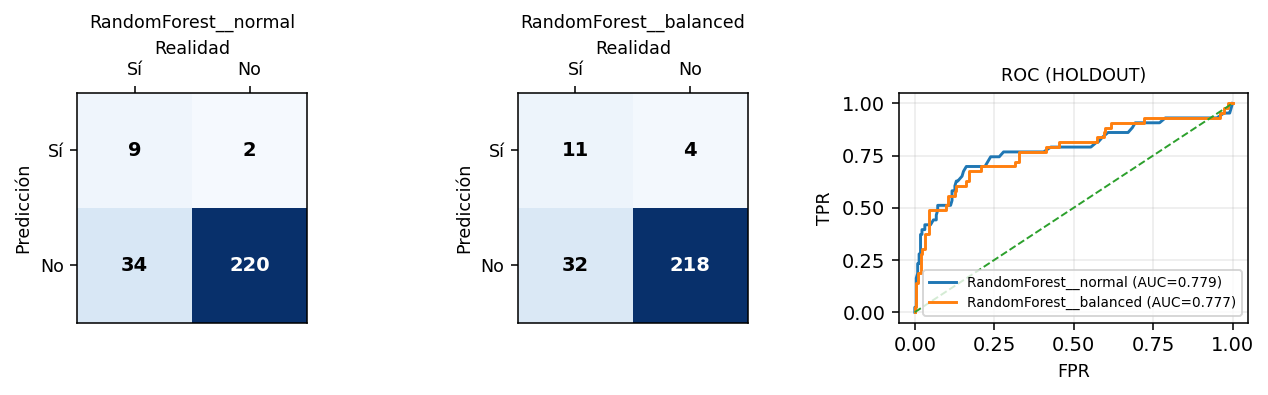

In [19]:
# ==============================
# REPORTE DE ESCENARIO — HOLDOUT
# ==============================

# ------------------------------------------------------------
# Reporting.plot_scenario_report(...):
#   - Genera el reporte del escenario "S2" sobre el conjunto HOLDOUT, usando el mismo
#     DataFrame de resultados y etiquetas reales para mantener comparabilidad con otros escenarios.
#   - Se usa para contrastar desempeño/configuración del escenario S2 frente a S1 u otros:
#       * cambios de features / preprocesamiento / umbrales / modelo (según pipeline)
#       * impacto en métricas y patrones de error en datos no vistos
#
#   - Parámetros:
#       * "S2"               → identificador del escenario (títulos, tracking, comparación).
#       * cfg                → configuración común del experimento/reporte.
#       * RESULTS_HOLDOUT_DF  → predicciones/resultados del holdout (base para gráficos/métricas).
#       * y_test             → ground truth del holdout para evaluación.
#       * plt                → matplotlib.pyplot para renderizado.
#       * scores_store       → almacén de métricas del holdout (persistencia y comparación).
#       * set_name="HOLDOUT" → etiqueta explícita del set evaluado.
#
#   - Notas técnicas:
#       * Asegurar alineación entre `RESULTS_HOLDOUT_DF` y `y_test` para evitar métricas inválidas.
#       * Si `scores_store` se reutiliza, las claves deberían diferenciar escenarios ("S1", "S2").
# ------------------------------------------------------------
Reporting.plot_scenario_report(
    "S2",
    cfg,
    RESULTS_HOLDOUT_DF,
    y_test,
    plt,
    scores_store=HOLDOUT_SCORES,
    set_name="HOLDOUT"
)


In [20]:
# ==============================
# REPORTE DE ESCENARIO — HOLDOUT
# ==============================

if RUN_THIS_CELL:
    # ------------------------------------------------------------
    # Reporting.plot_scenario_report(...):
    #   - Genera el reporte del escenario "S3" evaluado sobre el conjunto HOLDOUT.
    #   - Permite comparar S3 contra escenarios previos (S1/S2) bajo el mismo set_name,
    #     destacando diferencias de rendimiento y comportamiento de error en datos no vistos.
    #
    #   - Parámetros:
    #       * "S3"               → identificador del escenario (rotulado y trazabilidad).
    #       * cfg                → configuración del reporte/experimento.
    #       * RESULTS_HOLDOUT_DF  → resultados/predicciones del holdout usados para el reporte.
    #       * y_test             → etiquetas reales para cálculo/validación de métricas.
    #       * plt                → matplotlib.pyplot para renderizado de gráficos.
    #       * scores_store       → estructura donde se guardan métricas del holdout por escenario.
    #       * set_name="HOLDOUT" → etiqueta del conjunto evaluado (consistencia en reportes).
    #
    #   - Notas técnicas:
    #       * Verificar que `RESULTS_HOLDOUT_DF` corresponda al escenario S3 o que el reporte
    #         seleccione internamente la columna/modelo adecuado para S3.
    #       * Alineación `RESULTS_HOLDOUT_DF` ↔ `y_test` es crítica para métricas correctas.
    # ------------------------------------------------------------
    Reporting.plot_scenario_report(
        "S3",
        cfg,
        RESULTS_HOLDOUT_DF,
        y_test,
        plt,
        scores_store=HOLDOUT_SCORES,
        set_name="HOLDOUT"
    )


In [21]:
# ==============================
# ENTRENAMIENTO FULL Y PERSISTENCIA
# ==============================

if RUN_THIS_CELL:
    # ------------------------------------------------------------
    # Training.run_full_train_and_persist(...):
    #   - Entrena variantes con TODO (X, y) y guarda modelos/artefactos en `MODELS_DIR`.
    #   - Retorna:
    #       * saved_df → registro de guardado (modelo/ruta/metadata)
    #       * MODELS_FULL_DIR → directorio final de salida
    #       * saved_names → nombres guardados
    #       * models_to_persist → modelos efectivamente persistidos
    # ------------------------------------------------------------
    saved_df, MODELS_FULL_DIR, saved_names, models_to_persist = Training.run_full_train_and_persist(
        MODEL_VARIANTS=MODEL_VARIANTS,
        preprocessor=preprocessor,
        X=X,
        y=y,
        models_dir=MODELS_DIR,
        results_holdout_df=RESULTS_HOLDOUT_DF
    )

    # ------------------------------------------------------------
    # Salida rápida:
    #   - Cantidad de modelos FULL guardados + tabla de registro.
    # ------------------------------------------------------------
    print(f"Modelos FULL guardados: {len(models_to_persist)}")
    display(saved_df)


In [22]:
# ==============================
# SELECCIÓN DE GANADORES POR ESCENARIO
# ==============================

if RUN_THIS_CELL:
    # ------------------------------------------------------------
    # ModelManager.select_winners_by_scenarios(...):
    #   - Selecciona el mejor modelo por escenario usando `RESULTS_HOLDOUT_DF` y reglas de `cfg`.
    #   - Retorna:
    #       * winners    → estructura con ganadores por escenario (id/modelo/métricas clave).
    #       * yaml_block → bloque YAML listo para pegar en `config.yml` (sección `winners`).
    # ------------------------------------------------------------
    winners, yaml_block = ModelManager.select_winners_by_scenarios(cfg, RESULTS_HOLDOUT_DF)

    # ------------------------------------------------------------
    # Salida:
    #   - Imprime el bloque YAML final para actualizar configuración sin edición manual.
    # ------------------------------------------------------------
    print("\n✅ Pega esto en el config.yml en la sección winners del final del archivo:\n")
    print(yaml_block)


In [23]:
# Cosas a añadir: Feature engineering
# Balanceo de clases: Smote
# Lasso
# Outliers
# Label Encoding - Ordinal Encoding (sklearn), One-Hot Encoding (OHE), Encoding por frecuencia, Target Encoding (conceptual / avanzado)
# RobustScaler